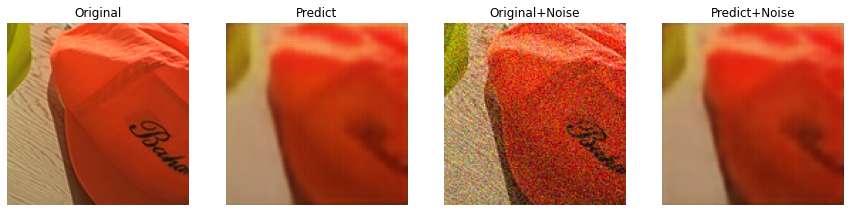

In [1]:
import os, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from matplotlib import pyplot as plt
from utils.image_handler import *

encoder = tf.keras.models.load_model('./saved_models/ssdcae/encoder/')
decoder = tf.keras.models.load_model('./saved_models/ssdcae/decoder/')
img = cv2.imread('imgs/kodim03.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = random_crop(img, (128, 128))
img_noise = (add_noise(img/255, sigma=.1)*255).astype('uint8')

latent = encoder.predict(np.expand_dims(img/255, axis=0))
recon = decoder.predict(latent)
recon = (recon*255).reshape((128, 128, 3)).astype('uint8')
latent_noise = encoder.predict(np.expand_dims(img_noise/255, axis=0))
recon_noise = decoder.predict(latent_noise)
recon_noise = (recon_noise*255).reshape((128, 128, 3)).astype('uint8')

fig, axs = plt.subplots(1, 4, figsize=(15, 15))

axs[0].imshow(img)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(recon)
axs[1].set_title('Predict')
axs[1].axis('off')

axs[2].imshow(img_noise)
axs[2].set_title('Original+Noise')
axs[2].axis('off')
axs[3].imshow(recon_noise)
axs[3].set_title('Predict+Noise')
axs[3].axis('off')
plt.show()

In [2]:
import zlib, sys, time
sample = np.expand_dims(img/255, axis=0)

def encode(sample):
    return encoder.predict(np.expand_dims(img/255, axis=0))
def decode(latent):
    return decoder.predict(latent)
def compress(x):
    compressed_data = zlib.compress(x, level=9) # -1 is fastest but least compression, max at 9
    return compressed_data
def decompress(x):
    decompressed_data = zlib.decompress(x)
    return decompressed_data

t0 = time.time()
latent = encode(sample)
t1 = time.time()
recon = decode(latent)
t2 = time.time()

vt = np.around(latent, decimals=2)
np.savetxt('img_vt_uncom', vt, fmt='%.2f')
# compresss encode vector
read_back = open('img_vt_uncom', 'r').read()
read_back_bytes = str.encode(read_back)

t3 = time.time()
compressed_data = compress(read_back_bytes)
t4 = time.time()
decompressed_data = decompress(compressed_data)
t5 = time.time()

compressed_time = t4-t3
decompressed_time = t5-t4
encode_time = t1-t0
decode_time = t2-t1

print(f'Raw Size: {sys.getsizeof(read_back)}\
\nCompressed Size: {sys.getsizeof(compressed_data)}\
\nCompressing Time: {compressed_time}s\
\nDecompressing Time: {decompressed_time}s\
\nEncoding Time: {encode_time}s\
\nDecoding Time: {decode_time}s\
\nCompression Rate: {100*(sys.getsizeof(compressed_data)/sys.getsizeof(read_back))} %')

# save compressed data as bytes file
open('test_savefile', 'wb').write(compressed_data)

Raw Size: 10723
Compressed Size: 3223
Compressing Time: 0.0013263225555419922s
Decompressing Time: 8.7738037109375e-05s
Encoding Time: 0.027414560317993164s
Decoding Time: 0.03226804733276367s
Compression Rate: 30.05688706518698 %


3190

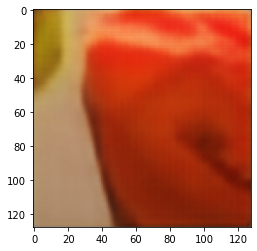

In [4]:
# compare decompressed image with no compressed image
bytes_com = open('test_savefile', 'rb').read()
bytes_decom = zlib.decompress(bytes_com)
# bytes_decom.decode('utf-8')
enc_decom = np.fromstring(bytes_decom.decode('utf-8'), sep=' ')
dec_img = decoder.predict(np.expand_dims(enc_decom, axis=0))
dec_img = (dec_img*255).astype('uint8')[0]
plt.imshow(dec_img)
plt.show()